In [1]:
%load_ext autoreload
%autoreload 2<

In [63]:
import pim
import pickle
import numpy as np
import matplotlib.pyplot as plt
import subprocess

from random import uniform
from scipy.optimize import minimize
from pim.models.new.stone import trials, plotter


In [5]:
def descend(T_inbound=1500, T_outbound=1500, noise=0.1, 
            phi=(0.1,1.0),beta=(0.0,1.0),T_half=(0.5,5.0),
            epsilon=(1e1,1e5),l=(1e-4,1e-3),c_tot=(1e-8,0.3)):

    bounds = [phi, beta, T_half, epsilon, l, c_tot]
    initial = np.array([uniform(a,b) for a,b in bounds])

    headings, velocities = trials.generate_route(T = 1500, vary_speed = True)

    with open("path.pickle", "wb") as f:
        pickle.dump((headings.tolist(), velocities.tolist()), f)


    def fastbee(x, *args):

        subprocess.run(['../../fastbee/target/release/fastbee', *[str(param) for param in x], str(noise)])

        with open("path.pickle", "rb") as outbound, open("inbound.pickle", "rb") as inbound:
            out_path = pickle.load(outbound)
            in_path = pickle.load(inbound)

        v = out_path[1] + in_path[1]

        position = np.zeros(2)
        path = [position]
        for velocity in v:
            position = position + velocity
            path.append(position)

        closest = min(path[T_outbound:], key = np.linalg.norm)
        return np.linalg.norm(closest)

    result = minimize(fastbee, x0=initial, bounds=bounds, tol=1e-7)

    return result

In [6]:
res = descend(
    phi=(0.001,0.9),
    beta=(0.01,10.0),
    T_half=(0.1,10.0),
    epsilon=(1e3,1e4),
    l=(1e-5,1e-3),
    c_tot=(1e-2,3e-1),
    noise=0.1
)

print(res)

      fun: 74.34599443098436
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.52374154e+09,  2.95111561e+09,  6.66094418e+09,  4.51818500e+09,
        3.05376523e+09, -2.06196273e+07])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 371
      nit: 4
     njev: 53
   status: 2
  success: False
        x: array([6.14479697e-01, 5.41543109e+00, 2.22983971e+00, 8.22229145e+03,
       5.32930377e-04, 1.63104572e-02])


In [ ]:
avg = 0
N = 50

if res:
    for i in range(N):
        headings, velocities = trials.generate_route(T = 1500, vary_speed = True)

        with open("path.pickle", "wb") as f:
            pickle.dump((headings.tolist(), velocities.tolist()), f)

        subprocess.run(['../../fastbee/target/release/fastbee', *[str(param) for param in res.x], str(0.1)])

        with open("path.pickle", "rb") as outbound, open("inbound.pickle", "rb") as inbound:
            out_path = pickle.load(outbound)
            in_path = pickle.load(inbound)

        v = out_path[1] + in_path[1]

        position = np.zeros(2)
        path = [position]
        for velocity in v:
            position = position + velocity
            path.append(position)

        closest = min(path[1500:], key = np.linalg.norm)
        avg += np.linalg.norm(closest)

    print(avg/N)

In [74]:
def run_sims(params, N=10, noise=0.1):
    avg = 0
    for i in range(N):
        headings, velocities = trials.generate_route(T = 1500, vary_speed = True)

        with open("path.pickle", "wb") as f:
            pickle.dump((headings.tolist(), velocities.tolist()), f)

        subprocess.run(['../../fastbee/target/release/fastbee', *[str(param) for param in params], str(noise)])

        with open("path.pickle", "rb") as outbound, open("inbound.pickle", "rb") as inbound:
            out_path = pickle.load(outbound)
            in_path = pickle.load(inbound)

        v = out_path[1] + in_path[1]

        position = np.zeros(2)
        path = [position]
        for velocity in v:
            position = position + velocity
            path.append(position)

        closest = min(path[1500:], key = np.linalg.norm)
        avg += np.linalg.norm(closest)
    return avg/N


def random_hypersphere_point(n, radius, center):
    #fill a list of n random values
    points = [np.random.uniform(-1.0, 1.0) for r in range(n)]
    #calculate 1 / sqrt of sum of squares
    sqr_red = 1.0 / np.sqrt(sum(i*i for i in points))
    #multiply each point by scale factor 1 / sqrt of sum of squares
    res = np.array(list(map(lambda x: x * sqr_red, points)))
    res *= radius
    res += center
    return res


def random_search(max_iter=10, N=10, phi=(0.01,1.0), beta=(0.001,10.0), T_half=(0.1,10.0),
                epsilon=(1e4,1e5), l=(1e-4,1e-3), c_tot=(0.01,0.3)): # R^n --> R fitness function to be minimized
    # initialize position x in the search space

    # until termination condition is reached:
    #       Sample new pos y from hypersphere of a given radius surrounding point x
    #       if f(y) < f(x), move to new position by setting x = y

    bounds = [phi, beta, T_half, epsilon, l, c_tot]
    x = np.array([np.random.uniform(a,b) for a,b in bounds])
    
    min_dist = run_sims(params=x, N=N)
    i = 0

    while min_dist > 10 and i != max_iter:
        y = random_hypersphere_point(x.size,0.1,x)
        f_y = run_sims(params=y,N=N)
        if f_y < min_dist: 
            x = y
            min_dist = f_y
        i += 1
    
    return [min_dist, x]


In [81]:
res = random_search(max_iter=100,N=20)
print(res)

KeyboardInterrupt: 

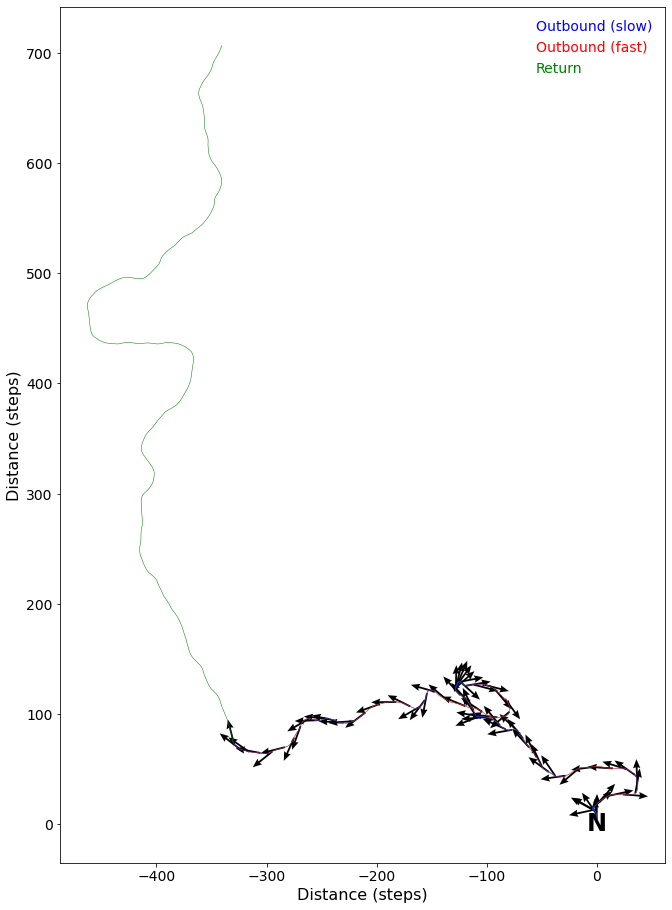

In [79]:
headings, velocities = trials.generate_route(T = 1500, vary_speed = True)

with open("path.pickle", "wb") as f:
    pickle.dump((headings.tolist(), velocities.tolist()), f)

subprocess.run(['../../fastbee/target/release/fastbee', *[str(param) for param in res[1]], str(0.1)])

with open("path.pickle", "rb") as outbound, open("inbound.pickle", "rb") as inbound:
    out_path = pickle.load(outbound)
    in_path = pickle.load(inbound)
    
fig, ax = plotter.plot_route(
    h = out_path[0] + in_path[0],
    v = out_path[1] + in_path[1],
    T_outbound = len(out_path[0]),
    T_inbound = len(in_path[0]),
    plot_speed = True,
    plot_heading = True,
    quiver_color = "black",
    )
plt.show()